In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="white")
from pyearth import Earth
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics as metrics
from scipy.stats import entropy
import math
from pyearth import export
from sympy import *
import copy
import matplotlib.transforms as transforms
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch, Wedge
from matplotlib.collections import PatchCollection
from IPython.core.pylabtools import figsize

In [2]:
data = pd.read_csv('/home/fotis/dev_projects/spark_test/target/crimes_AVG_data/part-cleaned-normalized.csv', sep=",", header=0)
data2 = pd.read_csv('/home/fotis/dev_projects/spark_test/target/crime_results_AVG/uni-x__uni-l_varx-0.01_multimodal-CONNECTED-l(0.02_0.04_0.06)/part-00000/part-00000', sep=",", header = None)

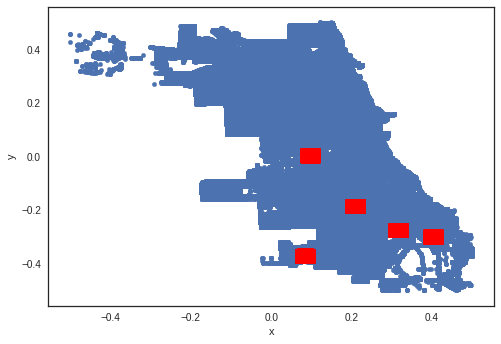

In [3]:
data.columns = ['ix','x','y','update_in_days']
data2.columns = ['x','y','l','cardinality','average']
data2 = data2[data2['cardinality']>0]
data2 = data2.set_index(np.arange(data2.count()[0]))
fig = plt.figure()
ax = fig.add_subplot(111)
data.plot(kind='scatter', x='x',y='y',ax=ax)
data2.plot(kind='scatter', x='x',y='y', c='r', ax=ax)

2703.78345473
2645.42410451
2703.78345473


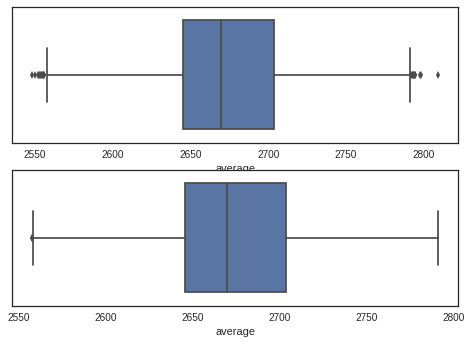

In [4]:
# data['update_in_days'].plot(kind='hist')
Q3 = data2.average.quantile(.75)
Q1 = data2.average.quantile(.25)
IQR = Q3 - Q1
print(Q3)
print(Q1)
print(Q3)
outlier_point_max = Q3+ 1.5 * IQR
outlier_point_min = Q1-1.5*IQR
fig = plt.figure()
ax = fig.add_subplot(211)
sns.boxplot(data2.average,ax=ax)
data2 = data2[data2.average < outlier_point_max]
data2 = data2[data2.average > outlier_point_min]
ax = fig.add_subplot(212)
sns.boxplot(data2.average,ax=ax)

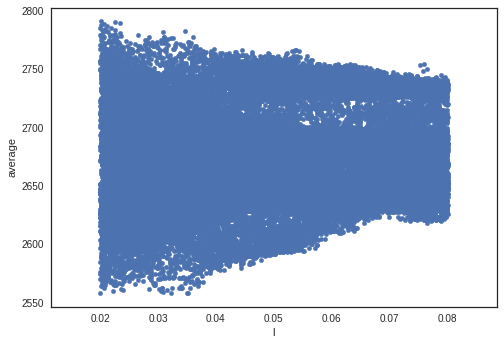

In [5]:
data2.plot(kind='scatter', x='l', y='average')

In [6]:
min_of_average = data2['average'].min()
max_of_average = data2['average'].max()
xmin = data['x'].min()
xmax = data['x'].max()
ymin = data['y'].min()
ymax = data['y'].max()
lmin = data2['l'].min()
lmax = data2['l'].max()
print("Minimum average : {0}\nMaximum average : {1}".format(min_of_average, max_of_average))
print("Xmin :{0}\nXmax: {1}".format(xmin, xmax))
print("Ymin : {0}\nYmax : {1}".format(ymin, ymax))
print("Lmin : {0}\nLmax : {1}".format(lmin, lmax))

Minimum average : 2557.91179191
Maximum average : 2791.07560121
Xmin :-0.5
Xmax: 0.5
Ymin : -0.5
Ymax : 0.5
Lmin : 0.0200023219023
Lmax : 0.0799977620284


<h2>Normalizing values</h2></br>
$$X_{norma} = \frac{X - min(X)}{max(X) - min(X)}$$

In [7]:
#Normalize all values to (0,1)
data['x'] = (data['x'] - xmin) / (xmax - xmin)
data['y'] = (data['y'] - ymin) / (ymax - ymin)
#Normalize all values for queries to (0,1)
data2['x'] = (data2['x'] - xmin) / (xmax - xmin)
data2['y'] = (data2['y'] - ymin) / (ymax - ymin)
data2['l'] = (data2['l'] - lmin) / (lmax - lmin)
# data2['cardinality'] = (data2['cardinality'] - min_of_cardinality) / (max_of_cardinality - min_of_cardinality)

/home/fotis/.local/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


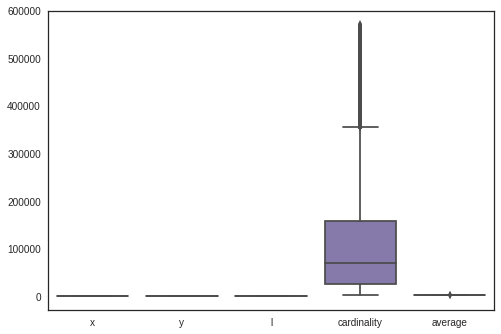

In [8]:
sns.boxplot(data2)

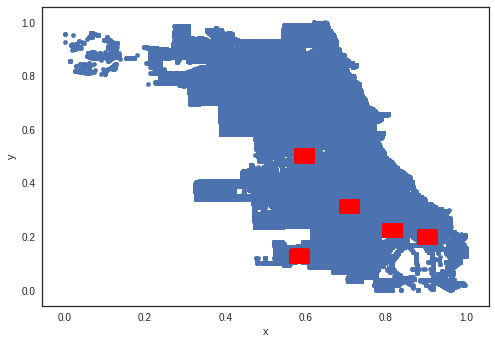

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
data.plot(kind='scatter', x='x',y='y',ax=ax)
data2.plot(kind='scatter', x='x',y='y', c='r', ax=ax)

<h2>Pre-Learning Phase 1st Level Clustering $$\mathbf{x}$$</h2></br>
<b>Cluster and train model for sample 0.2 of queries</b>

In [10]:
prelearningdf = data2.sample(frac=.2)
trainingdf = data2.drop(prelearningdf.index)

In [11]:
print("Resulting prelearning set : {0}\nResulting training set : {1}".format(prelearningdf.count()[0], trainingdf.count()[0]))

Resulting prelearning set : 9995
Resulting training set : 39980


<b>Resetting Indexes</b>

In [12]:
prelearningdf = prelearningdf.set_index(np.arange(prelearningdf.count()[0]))
trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))

In [13]:
testingdf = trainingdf.sample(frac=.2)
trainingdf = trainingdf.drop(testingdf.index)
print("Resulting training set : {0}\nResulting testing set : {1}".format(trainingdf.count()[0], testingdf.count()[0]))
trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))
testingdf = testingdf.set_index(np.arange(testingdf.count()[0]))

Resulting training set : 31984
Resulting testing set : 7996


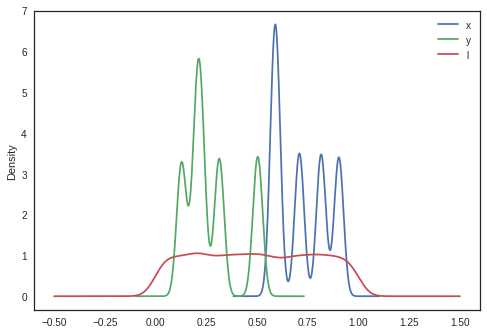

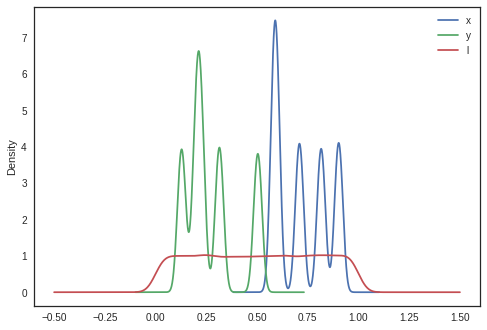

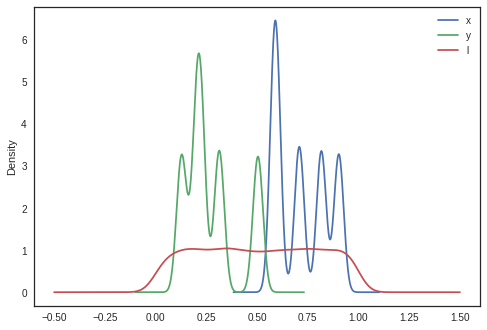

In [14]:
prelearningdf[['x','y','l']].plot(kind='kde')
trainingdf[['x','y','l']].plot(kind='kde')
testingdf[['x','y','l']].plot(kind='kde')

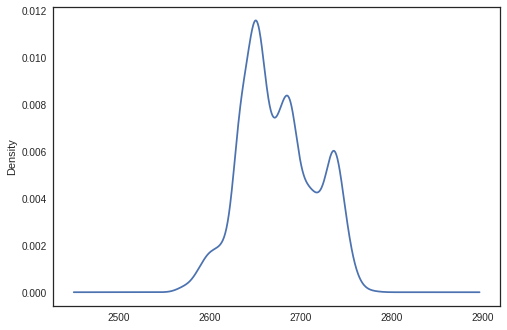

In [15]:
testingdf['average'].plot(kind='kde')

In [16]:
# prelearningdf['cardinality'] = (prelearningdf['cardinality'] - min_of_cardinality) / (max_of_cardinality - min_of_cardinality)
X = prelearningdf[['x','y']].as_matrix()

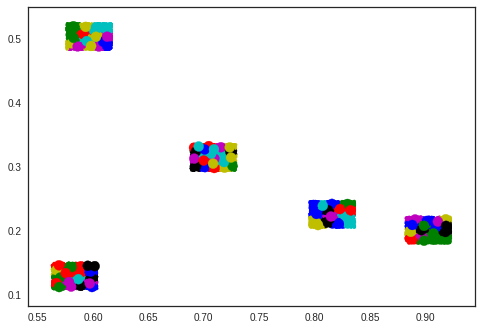

In [17]:
# # Tuning k-parameter for kmeans
vigil = 0.008
avg_vars = []
c=20
# for c in clusters_:
#     var = 0
#     kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
#     kmeans.fit(X)
#     avg_vars.append(kmeans.inertia_)
init = True
diff = 1
while diff>= vigil:
    kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
    kmeans.fit(X)
    avg_vars.append(kmeans.inertia_)
    if not init:
        diff = (avg_vars[-2]-avg_vars[-1])
    else:
        init=False
    c+=5
c-= 5    
#End of tuning

CLUSTERS =  c
kmeans = MiniBatchKMeans(n_clusters=CLUSTERS)
kmeans.fit(X)
if hasattr(kmeans, 'labels_'):
    y_pred = kmeans.labels_.astype(np.int)
else:
    y_pred = kmeans.predict(X)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * CLUSTERS)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(prelearningdf['x'],prelearningdf['y'],color=colors[y_pred].tolist(), s=10)

if hasattr(kmeans, 'cluster_centers_'):
    centers = kmeans.cluster_centers_
    center_colors = colors[:len(centers)]
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)

plt.show()

<b>Assigning Queries to clusters</b>

In [18]:
clusters = {}
# fig, axs = plt.subplots(ncols=5, nrows=15,figsize=(30,25))
for i in range(len(kmeans.cluster_centers_)):
    item = np.where(kmeans.labels_== i)
    clusters[i] = prelearningdf.ix[item]
#     sns.regplot(x='l', y='cardinality', data=clusters[i],fit_reg=False, ax=axs[(i/5)][(i%5)])

<b>Checking if cardinality variance is less within cluster than before</b>

In [19]:
#Is the variance lower when clustering ?
t = 0
for i in clusters:
    if clusters[i]['average'].var() < data2['average'].var():
        t+= 1
print("Variance lower when clustering : %d/%d , probability %f" % (t,len(kmeans.cluster_centers_), float(t)/len(kmeans.cluster_centers_)))

Variance lower when clustering : 90/90 , probability 1.000000


In [20]:
# for i in clusters:
#     print("Cluster {0}, variance : {1}".format(i,clusters[i]['cardinality'].var()))

<h2>Pre-Learning 2nd Level cluster $$\theta$$</h2>
<b>Cluster theta</b>

0.084168379382


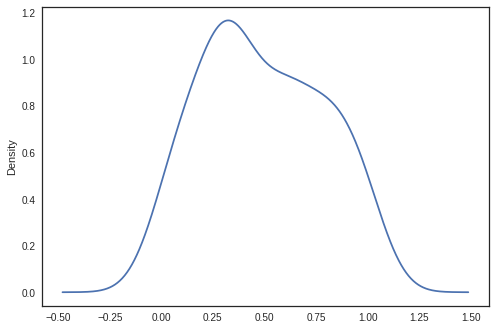

In [21]:
#Showing that within each cluster the distribution of theta is multi-modal and thus needs to be reclustered.
clusters[0]['l'].plot(kind='kde')
print(clusters[0]['l'].var())

In [22]:
# figsize(25,12)
# counts = []
# for c in clusters:
#     counts.append(clusters[c].count()[0])
# sns.barplot(x=range(0, len(counts)), y=counts)

<b>Resetting indexes for each cluster because we need to re-cluster</b>

In [23]:
for i in clusters:
    clusters[i] = clusters[i].set_index(np.arange(clusters[i].count()[0]))

<b>Datastructure to hold each subcluster associated with a cluster</b>

<b>For every cluster, use a subclustering algorithm to cluster based on theta</b>

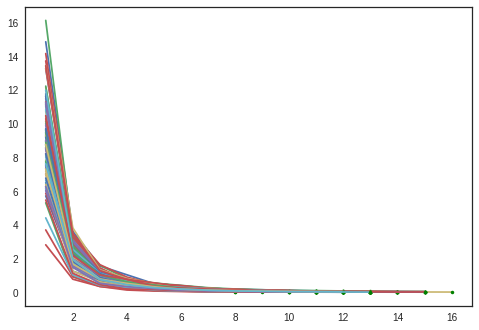

In [24]:
theta_centers = []
subclusters = []
#For each cluster
for j in clusters:
    T = clusters[j]['l'].as_matrix()
    #Tuning k-parameter for kmeans
    T = T.reshape(-1, 1)
    avg_vars = []
    vigil = 0.008
    avg_vars = []
    c=1
    # for c in clusters_:
    #     var = 0
    #     kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
    #     kmeans.fit(X)
    #     avg_vars.append(kmeans.inertia_)
    init = True
    diff = 1
    while diff>= vigil:
        t_kmeans = MiniBatchKMeans(n_clusters=c, max_no_improvement=None)
        t_kmeans.fit(T)
        avg_vars.append(t_kmeans.inertia_)
        if not init:
            diff = (avg_vars[-2]-avg_vars[-1])
        else:
            init=False
        c+=1
    c-= 1    

    avg_vars = np.array(avg_vars)
    selected = np.where(avg_vars == np.min(avg_vars))[0][0]
    plt.plot(range(1,c+1,1), avg_vars)
    plt.plot(c, avg_vars[selected],'.g')
#     #End of tuning
    subcluster = []
    CLUSTERS = selected
    t_kmeans = MiniBatchKMeans(n_clusters=CLUSTERS)
    t_kmeans.fit(T)
#     if hasattr(t_kmeans, 'labels_'):
#         t_pred = t_kmeans.labels_.astype(np.int)
#     else:
#         t_pred = kmeans.predict(T)
    theta_centers.append(t_kmeans.cluster_centers_)
    for i in range(CLUSTERS):
            item = np.where(t_kmeans.labels_== i)
            s = clusters[j].ix[item]
            subcluster.append(s)
        
    subclusters.append(subcluster)

In [25]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111, projection='3d')
# markers = ['o','v','x', '+']
# # ax.scatter(clusters[0]['x'],clusters[0]['y'],color=colors[y_pred].tolist(), s=10)
# i=0
# for s in subclusters[0]:
#         ax1.scatter(s['x'].as_matrix(),s['y'].as_matrix(),s['l'].as_matrix(), marker=markers[i])
#         i+=1

In [26]:
# n_cols = len(subclusters[0])
# fig, axs = plt.subplots(ncols=n_cols, nrows=len(subclusters[:20]),figsize=(30,25))
# sumc = 0
# for i in range(len(subclusters[:20])):
#     for j in range(len(subclusters[i])):
#         cluster = subclusters[i][j]
#         ax=axs[i][0]
#         cluster['l'].plot(kind='kde',ax=ax)
#         print("Cluster {0}/{1} mean is {2}".format(i,j, cluster['l'].mean()*(lmax - lmin) + lmin))

<b>Count for every subcluster and resetting indexes</b>

In [27]:
for i in range(len(subclusters)):
    for j in range(len(subclusters[i])):
#         print("Count for subcluster {0}/{1} : {2}".format(i,j,subclusters[i][j].count()[0]))
        #Reset index trainingdf = trainingdf.set_index(np.arange(trainingdf.count()[0]))
        subclusters[i][j] = subclusters[i][j].set_index(np.arange(subclusters[i][j].count()[0])) 

<b>Creating MARS models (one per SUB-cluster)</b>

In [28]:
#Fit an Earth model for each cluster
# f, axarr = plt.subplots(10, 2,figsize=(35,35))
models = [{} for i in range(len(subclusters))]
r2_avg = 0
rmse_avg = 0
r2_for_model = {}
rmse_for_model = {}
for i in range(len(subclusters)):
    for j in range(len(subclusters[i])):
        tcluster = subclusters[i][j]
        XX = tcluster['l'].as_matrix()
        yy = tcluster['average'].as_matrix()
#         X_train, X_test, y_train, y_test = train_test_split(
#              XX, yy, test_size=0.1, random_state=42)
        model = Earth(max_degree=1)
        model.fit(XX,yy)
        models[i][j] = [model]
        y_hat = model.predict(XX)
        r2 = metrics.r2_score(yy, y_hat)
        rmse = np.sqrt(model.mse_)
        r2_for_model[i] = r2
        rmse_for_model[i] = rmse
        r2_avg+=r2
        rmse_avg+=rmse
#         print("Model for cluster {0} subcluster {4}, R2 : {1}, RMSE :{2}, Size of Sample : {3}".format(i,r2,rmse,tcluster.count()[0],j))

In [29]:
# n_cols = len(subclusters[0])
# fig, axs = plt.subplots(ncols=n_cols, nrows=len(subclusters[:30]),figsize=(30,25))
# sumc = 0
# for i in range(len(subclusters[:30])):
#     for j in range(len(subclusters[i])):
#         cluster = subclusters[i][j]
#         sumc+= cluster.count()[0]
#         ax=axs[i][j]
#         sns.regplot(x='l', y='average', data=cluster,fit_reg=False, ax=ax)
#         ax.plot(np.sort(cluster['l']), models[i][j][0].predict(np.sort(cluster['l'].as_matrix())), 'g')

In [30]:
# n_cols = len(subclusters[0])
# fig, axs = plt.subplots(ncols=n_cols, nrows=len(subclusters),figsize=(30,25))
# sumc = 0
# for i in range(len(subclusters)):
#     for j in range(len(subclusters[i])):
#         cluster = subclusters[i][j]
#         sumc+= cluster.count()[0]
#         ax=axs[i][0]
#         sns.regplot(x='l', y='cardinality', data=cluster,fit_reg=False, ax=ax)
#         ax.plot(cluster['l'], models[i][j][0].predict(cluster['l'].as_matrix()), '.g')

In [31]:
#PROBELMATIC len of sublcusters might not be the same for each subcluster
print("Average R2 : %f" % (r2_avg/(len(subclusters*len(subclusters[0])))))
print("Average RMSE : %f" % (rmse_avg/(len(subclusters*len(subclusters[0])))))

Average R2 : 0.095133
Average RMSE : 7.008299


<h2>Training phase</h2>

In [32]:
online = trainingdf[['x','y','l','average']].as_matrix()

<h3>Switch Between Scenarios</h3>

In [33]:
selected_scenario = 2

<b>Scenario 2</b>
- Go to closest clusterhead 
$$w_k = argmin_k \lVert \mathbf{w}_k - \mathbf{x'} \rVert $$ 
- Go to theta clusterhead with the miunimum prediction error and distance from query's theta. <b>Lambda</b> is a tunable parameter
$$\theta_{k,j} = argmin_j  \lambda(\theta'-\theta_{k,j})^2 + (1-\lambda)(\hat{y_{k,j}} - y')^2$$

In [35]:
if selected_scenario == 2:
    print("Executing Scenario 2")
    #Reset cluster centers as well
    ALPHA = 0.01
    LAMBDA = 0.2
    subclusters_copy = copy.deepcopy(subclusters)
    theta_centers_copy = copy.deepcopy(theta_centers) #theta positions (multiple for each clusterhead)
    cluster_centers = copy.copy(kmeans.cluster_centers_) # x posistions of clusterheads
    new_models = copy.deepcopy(models)
    n_s = 20
    t = 1 # every 20 , retrain ONLY affected MARS models
    affected = [] #Keep a list of affected models to retrain only them
    keys = ['x','y','l','average']
    side_experiment_counter = 0
    side_experiment_2 = 0
    side_experiment_3 = 0
    for q in online:
        dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
        closest_x = np.argmin(dist)
        #Scenario 2 Go to closest X and then to theta with lowest error
        dist_t = ((theta_centers_copy[closest_x]-q[2])**2).T
        preds = []
        for m in new_models[closest_x]:
            preds.append(float(new_models[closest_x][m][-1].predict([q[2]])))
    #     preds = [float(new_models[m][-1].predict([q[2]])) for m in new_models] #Prediction for each latest model
        preds = np.array(preds)
        errors = np.sqrt((preds-q[3])**2) #Error between prediction and each model (y-y_hat)**2
        #Normalize errors
        errors = (errors-0) / (max_of_average-0)

        total_distance = LAMBDA*dist_t +  (1-LAMBDA)*errors # Distance from x  + distance from theta cluster
        

        closest_t = np.argmin(total_distance)
#         print(closest_t)
        closest = (closest_x, closest_t)
        #Side experiment : number of times closest distance wise gives smallest prediction error
        distwise = np.argmin(dist_t)
        errorwise = np.argmin(errors)
        side_experiment_counter+= distwise==errorwise
        side_experiment_2 += distwise==closest_t
        side_experiment_3 += errorwise==closest_t and errorwise!=distwise
        #Adding to cluster
        dictionarize = dict(zip(keys, q.T))
        subclusters_copy[closest[0]][closest[1]] = subclusters_copy[closest[0]][closest[1]].append(dictionarize, 
                                                                                                   ignore_index=True)
        #Readjust theta
        theta_centers_copy[closest[0]][closest[1]] += ALPHA*(q[2] - theta_centers_copy[closest[0]][closest[1]])
        #Retraining every n_s steps
        affected.append(closest)
        if (t%n_s)==0:
            for tpl in set(affected):
                model = Earth(max_degree=1, max_terms=20)
                xtrain_o = subclusters_copy[tpl[0]][tpl[1]]['l'].as_matrix()
                ytrain_o = subclusters_copy[tpl[0]][tpl[1]]['average'].as_matrix()
                m = model.fit(xtrain_o, ytrain_o)
                new_models[tpl[0]][tpl[1]].append(m) #Append a new model
            affected = []
        t+=1

Executing Scenario 2


In [36]:
#Side experiment results
print(side_experiment_counter)
print("Probability of closest distance wise thetaclusterhead having the smallest error {0}".format(float(side_experiment_counter) /len(online)))
print("Times prediction error won {0}".format(1.0*side_experiment_3/len(online)))
print("Times distance error won {0}".format(1.0*side_experiment_2/len(online)))

9995
Probability of closest distance wise thetaclusterhead having the smallest error 0.3125
Times prediction error won 0.147511255628
Times distance error won 0.734054527264


In [37]:
avg_lines = 0
count = 0
for i in new_models:
    for j in i:
        avg_lines += (i[j][-1].coef_.shape[1])-1
        count+=1
print(avg_lines/float(count))

0.622418879056


In [ ]:
# n_cols = len(subclusters[0])
# fig, axs = plt.subplots(ncols=n_cols, nrows=len(subclusters[:30]),figsize=(30,25))
# sumc = 0
# for i in range(len(subclusters_copy[:30])):
#     for j in range(len(subclusters_copy[i])):
#         cluster = subclusters_copy[i][j]
#         sumc+= cluster.count()[0]
#         ax=axs[i][j]
#         sns.regplot(x='l', y='average', data=cluster,fit_reg=False, ax=ax)
#         ax.plot(np.sort(cluster['l']), new_models[i][j][-1].predict(np.sort(subclusters_copy[i][j]['l'].as_matrix())), 'g')

<h2>Evaluation of advanced clustering algorithm on prediction</h2>

In [77]:
onlinetest = testingdf.as_matrix()

In [78]:
y_pred = []
y_actual = onlinetest[:,4]
for q in onlinetest:
    dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
    closest_x = np.argmin(dist)
    dist_t = (theta_centers_copy[closest_x]-q[2])**2
    closest_t = np.argmin(dist_t)
    y_hat = new_models[closest_x][closest_t][-1].predict([q[2]])
    y_pred.append(y_hat[0])
y_pred = np.array(y_pred)
print("R2 : {0}\nMSE: {1}".format(metrics.r2_score(y_actual, y_pred), np.sqrt(metrics.mean_squared_error(y_actual, y_pred))))

R2 : 0.947554805617
MSE: 9.47796755311


In [42]:
qs = testingdf[['x','y','l']].as_matrix()
data_asm = data[['x','y','update_in_days']].as_matrix()

In [43]:
y_Tests = []
sub_thetas = 10
for q in qs:
    l_denorm = q[2]*(lmax - lmin) + lmin
    #Create subqueries with smaller thetas starting from 0.01(init point of training) up to theta#
#     if q[2]<0.2:
#         squeries = np.linspace(l_denorm, lmax, sub_thetas) #CHANGED TO 0.02
#     else:
#         squeries = np.linspace(lmin, l_denorm, sub_thetas) #CHANGED TO 0.02
    squeries = np.linspace(lmin, l_denorm, sub_thetas)
    y_Test_a = []
    #Execute thetas and get actual y for stationary query
    distances_for_y = np.sqrt(np.sum(np.power(data_asm[:,:2]-q[:2],2),axis=1))
    for theta in squeries:
        dist_filter = data_asm[distances_for_y < theta]
        if len(dist_filter)==0:
            y_real = 0
        else:
            y_real = np.mean(dist_filter[:,2])
        y_Test_a.append(y_real)
    y_Test_a = np.array(y_Test_a)
    y_Tests.append(y_Test_a)

<b>Does choosing a model from a different timeline yield better results </b>

<h2>Begining evaluation on explanations</h2>

In [79]:
import time

avg_r2_me = 0
avg_r2_god = 0
avg_r2_knn = 0
avg_kl = 0
avg_r2_new = 0
probs = []
avg_relative_error = 0
record_times_closest = 0
sub_thetas = 10
query_index = 0 
#For all queries in testingdf
for q in qs:
    #Get closest clusters
    dist = np.linalg.norm(cluster_centers - q[:2],axis=1) #Calculate distances between all neurons
    closest_x = np.argmin(dist)
    dist_t = (theta_centers_copy[closest_x]-q[2])**2

    #First denormalize theta 
    y_Test_a = y_Tests[query_index]
#     y_Test_a = (y_Test_a - min_of_cardinality) / (max_of_cardinality - min_of_cardinality)
    l_denorm = q[2]*(lmax - lmin) + lmin

    squeries = np.linspace(lmin, l_denorm, sub_thetas) #CHANGED TO 0.02
    #Normalize squeries
    squeries = (squeries - lmin) / (lmax - lmin)
    #Create PLR for GOD
    model_god = Earth(max_degree=1, penalty=0, enable_pruning=False, max_terms=sub_thetas)
    model_god.fit(squeries, y_Test_a)
    god_predi = model_god.predict(squeries)
#     print(model_god.summary())
    #Create subqueries to be executed
    #Each query is executed from the same position but with a lesser theta
    mqueries = np.matrix([q] * sub_thetas)
    qqs = squeries.reshape((sub_thetas,1))
    mqueries[:,2] = 0
    mqueries[:,2] = qqs  
    #ME MARS MODEL
    #Change of strategy get closest model for each lesser theta.
    y_predi_c = []
    start_time = time.time()
    closests = []
    for theta in squeries:
        dist_t = (theta_centers_copy[closest_x]-theta)**2
        closest_t = np.argmin(dist_t)
        closests.append(closest_t)
        prediction = float(new_models[closest_x][closest_t][-1].predict([theta]))
        if prediction>0:
            y_predi_c.append(prediction)
        else:
            y_predi_c.append(0)
    t_of_execution_me = time.time() - start_time
    

    y_predi_c = np.array(y_predi_c)
#     y_predi_c = new_models[closest_x][closest_t][-1].predict(squeries)
#     y_predi_c[np.where(y_predi_c < 0)] = y_predi_c[np.where(y_predi_c < 0)] * -1 * 0
#     y_predi_c = y_predi_c*(max_of_cardinality - min_of_cardinality) + min_of_cardinality


    

    
    #knn  
    i = 0
    start_time = time.time()
    lr = LinearRegression()
    lr.fit(squeries.reshape(-1,1), y_Test_a)  
    knn_predi = lr.predict(squeries.reshape(-1,1))

    t_of_execution_knn = time.time() - start_time
    

    #Evaluation Scores
    coefs_me = []
    coefs_g = []
    coefs_a = []
    coefs_l = []
    #Slope of god
    for i in range(1,len(god_predi[1:])):
        #Slope
        paronomastis = squeries[i] - squeries[i-1]
        arithmitis = y_Test_a[i] - y_Test_a[i-1]
        #Predicted_slope
        arithmitis_me = y_predi_c[i] - y_predi_c[i-1]
        arithmitis_knn = knn_predi[i] - knn_predi[i-1]
        arithmitis_g = god_predi[i] - god_predi[i-1]
        v = arithmitis/paronomastis
        coefs_a.append(v)
        vapprox_m = arithmitis_me/paronomastis
        coefs_me.append(vapprox_m)
        vapprox_knn = arithmitis_knn/paronomastis
        coefs_l.append(vapprox_knn)
        vapprox_g = arithmitis_g/paronomastis
        coefs_g.append(vapprox_g)        

    
    coefs_me = np.array(coefs_me).reshape(1,-1)
    coefs_g = np.array(coefs_g).reshape(1,-1)
    coefs_a = np.array(coefs_a).reshape(1,-1)
    coefs_l = np.array(coefs_l).reshape(1,-1)
    #Cosine Similarity between coefficients
    cos_coef_m = float(metrics.pairwise.cosine_similarity(coefs_me, coefs_a))
    cos_coef_g = float(metrics.pairwise.cosine_similarity(coefs_g, coefs_a))
    cos_coef_l = float(metrics.pairwise.cosine_similarity(coefs_l, coefs_a))

    #KL-divergence metric
    #Transforming to probabilties
    p_actual = np.histogram(y_Test_a)[0]/10.0
    p_me = np.histogram(y_predi_c)[0]/10.0
    p_g = np.histogram(god_predi)[0]/10.0
    p_lin = np.histogram(knn_predi)[0]/10.0
    
    mask_me = np.where(p_me!=0)
    mask_g = np.where(p_g!=0)
    mask_l = np.where(p_lin!=0)

    kl_divergence = entropy(p_actual[mask_me], p_me[mask_me])
    kl_div_g = entropy(p_actual[mask_g], p_g[mask_g])
    kl_div_knn = entropy(p_actual[mask_l], p_lin[mask_l])
    entropy_p = entropy(p_actual)
    scaler = 1.0/entropy_p
    
    #R2 scores
    knn_r2_score = metrics.r2_score(y_Test_a, knn_predi )
    me_r2_score = metrics.r2_score(y_Test_a, y_predi_c)
    god_r2_score = metrics.r2_score(y_Test_a, god_predi)
    
    new_metric_m = 1 - ((np.sum(np.abs(y_Test_a - y_predi_c)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))
    new_metric_g = 1 - ((np.sum(np.abs(y_Test_a - god_predi)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))
    new_metric_knn = 1 - ((np.sum(np.abs(y_Test_a - knn_predi)))/(np.sum(np.abs(y_Test_a - np.mean(y_Test_a)))))
    
    #Averages
    avg_kl += kl_divergence
    avg_r2_knn += knn_r2_score
    avg_r2_me += me_r2_score
    avg_r2_god += god_r2_score
    avg_r2_new+=new_metric_m
    probs.append([closest_x, closest_t, me_r2_score, god_r2_score, knn_r2_score, 
                  new_metric_m, new_metric_g, new_metric_knn,
                  cos_coef_m, cos_coef_g, cos_coef_l,
                  kl_divergence, kl_div_g, kl_div_knn,entropy_p, scaler,
                  t_of_execution_me, t_of_execution_knn, q[0], q[1], q[2], np.var(y_Test_a)])
    query_index+=1


/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: divide by zero encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:130: RuntimeWarning: divide by zero encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:131: RuntimeWarning: divide by zero encountered in double_scalars
/home/fotis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:132: RuntimeWarning: invalid value encountered in double_scalars


In [45]:
sdf = pd.DataFrame(data=np.array(probs), index=range(len(probs)), columns=['closest_x','closest_t','r2_me','r2_god','r2_knn',
                                                                           'new_metric_m','new_metric_g', 'new_metric_knn',
                                                                           'cos_coef_m','cos_coef_g', 'cos_coef_l',
                                                                           'kl_me','kl_g','kl_knn',
                                                                           'entropy_p','scaler'
                                                                           ,'time_me','time_knn',
                                                                           'x','y','l', 'variance'])

In [85]:
sdf.to_csv(path_or_buf='/home/fotis/Dropbox/PhD/10.July - 2017/eval_results/eval_uni_uni-AVG-Crimes.csv')

In [ ]:
sdf = sdf.replace([np.inf, -np.inf], np.nan).dropna()

In [84]:
sdf.median()

closest_x          31.000000
closest_t           5.000000
r2_me               0.799123
r2_god              0.651105
r2_knn              0.651105
new_metric_m        0.667468
new_metric_g        0.427497
new_metric_knn      0.427497
cos_coef_m          0.812696
cos_coef_g          0.396106
cos_coef_l          0.396106
kl_me               0.331024
kl_g                0.606843
kl_knn              0.606843
entropy_p           1.695743
scaler              0.589712
time_me             0.000625
time_knn            0.000229
x                   0.776678
y                   0.326468
l                   0.393915
variance          471.156608
dtype: float64

0.912779324508
0.556406100448
0.912779324508


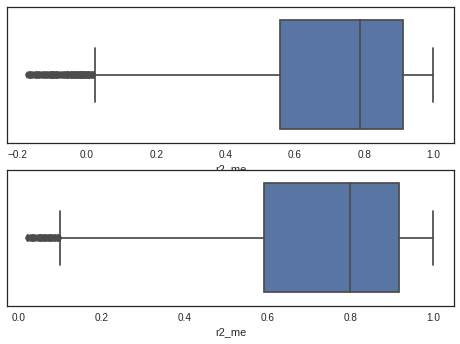

In [82]:
# data['update_in_days'].plot(kind='hist')
Q3 = sdf.r2_me.quantile(.75)
Q1 = sdf.r2_me.quantile(.25)
IQR = Q3 - Q1
print(Q3)
print(Q1)
print(Q3)
outlier_point_max = Q3+ 1.5 * IQR
outlier_point_min = Q1-1.5*IQR
fig = plt.figure()
ax = fig.add_subplot(211)
sns.boxplot(sdf.r2_me,ax=ax)
sdf = sdf[sdf.r2_me < outlier_point_max]
sdf = sdf[sdf.r2_me > outlier_point_min]
ax = fig.add_subplot(212)
sns.boxplot(sdf.r2_me,ax=ax)

In [ ]:
sdf['average'] = testingdf['average']

In [83]:
sdf.r2_me.median()

0.7991226510769582